# Calcul parallel

JULIA dans sa grande force permet nativement le calcul parallel plus précisément calcul parallel à mémoire partagée ou distribuée.

Le document référence officiel : http://julia.readthedocs.org/en/latest/manual/parallel-computing/

http://www.csd.uwo.ca/~moreno/cs2101a_moreno/Parallel_computing_with_Julia.pdf Très transparants très bien fait la notion de Task est abordée...

http://www.admin-magazine.com/HPC/Articles/Julia-Distributed-Arrays


http://www.admin-magazine.com/HPC/Articles/Parallel-Julia-Jumping-Right-In

http://www.blog.juliaferraioli.com/2014/02/julia-on-google-compute-engine-parallel.html

http://www.alshum.com/parallel-julia/

In [1]:
using PyPlot # pour afficher le résultat sur le noeud master

INFO: Loading help data...


En tout premier lieu on peut lancer une instance de JULIA avec plusieurs processeurs (ou plusieurs instances de JULIA) à l'aide de la commande shell

julia -p 4

Autrement on peut à la volée ajouter/enlever des processeurs ou plutôt workers à l'aide des commandes <code>addproc()</code> <code>rmproc()</code> et <code>worker()</code> ainsi que les commandes <code>nprocs</code> et <code>nworker</code> 

In [2]:
workers() # par défaut un worker le "maitre"

1-element Array{Int64,1}:
 1

In [3]:
addprocs(2) #ajout de 2 workers

2-element Array{Any,1}:
 2
 3

In [4]:
workers() # le processeur 1 n'est plus worker il est evenu master

2-element Array{Int64,1}:
 2
 3

# @parallel for

JULIA offre une façon simple de paralleliser une boucle for à l'aide de la macro @parallel

In [5]:
taille=7
@parallel for i=1:taille
    println(myid()); # renvoie le numéro du worker
end

In [6]:
myid() # numéro du processus maitre

1

Regardons plus exactement la répartition du calcul pour cela utilisons un tableau partagé <code>SharedArray</code> (voir également <code>SharedMatrix</code>, <code>SharedVector</code>). Autrement dit un tableau qui sera accessible en lecture et en écriture pour chaque worker (et le master).

In [7]:
taille=7
a = SharedArray(Int,(1,taille)) # Tableau partagé
@parallel for i=1:taille
    a[i]=myid(); # renvoie le numéro du worker stocké dans a
end

	From worker 2:	2
	From worker 3:	3
	From worker 3:	3
	From worker 3:	3
	From worker 2:	2
	From worker 2:	2
	From worker 2:	2


In [8]:
a

1x7 SharedArray{Int64,2}:
 2  2  2  2  3  3  3

La boucle à été partagée et envoyée pour i=1:4 sur le worher 2 et pour i=5:7 sur le worker 3.

Regardons si nous n'avions pas utilisr de tableau partagé

In [9]:
taille=7
a = zeros(taille) # Tableau non partagé il est ici en local myid()==1
 @parallel for i=1:taille
    a[i]=myid(); # renvoie le numéro du worker
    println(a)
end

On peut voire que localement les worker ont accès à une copie de a dont ils peuvent modifier les valeurs "localement". 

Par contre

In [10]:
println(a)

[0.0,0.0,0.0,0.0,0.0,0.0,0.0]


la valeur locale sur master n'a pas été modifiée. Autrement dit chaque worker a utilisé une copie locale de a, localement modifiable mais une fois l'execution terminée cette copie est effacée.

In [11]:
a = ones(taille)
@parallel for i=1:2
    println(a) # nouvelle copie locale
end

# Application :

Plaçons nous sur un exemple de calcul de bassin d'attraction de Newton

## premier calcul mono-processeur (temps de référence)

In [12]:
# algorithme de Newton
function newton(x0,f,df,epsi)
    k=0;
    x=x0;
    xnew=x-df(x)\f(x);
    while (norm(x-xnew)>epsi)&(k<1000)
        x=xnew
        xnew=x-df(x)\f(x);
    end
    return xnew
end
# fonction f(x)=0 à résoudre ici z=x+iy et f(z)=z^3-1
f(x)=[x[1]^3-3*x[1]*x[2]^2-1,3*x[1]^2*x[2]-x[2]^3]
# le jacobien de f
df(x)=[3*x[1]^2-3*x[2]^2 -6*x[1]*x[2];6*x[1]*x[2] 3*x[1]^2-3*x[2]^2]

# Calcul du bassin si on converge vers la Ieme racine suivant le point de départ
function calc_bassin(f,df,n)
    x=linspace(-1,1,n);
    y=linspace(-1,1,n);
    Imag=zeros(n,n);
    for i=1:n
        for j=1:n
            r=newton([x[i],y[n-j+1]],f,df,1e-10)
            Imag[j,i]=int(round(atan2(r[2],r[1])*3/pi)+3)%3;
        end
    end
    return Imag
end

calc_bassin (generic function with 1 method)

	From worker 3:	[0.0[,10.0.0,,10.0.0,,10.0.0,,13.0.0,,10.0.0,,10.0.0,]1
	From worker 2:	[2.0[,10.0.0,,10.0.0,,10.0.0,,10.0.0,,10.0.0,,10.0.0,]1


In [13]:
n=512
@time Imag=calc_bassin(f,df,n);

elapsed time: 	From worker 3:	.0][
	From worker 2:	.0][
7	From worker 3:	0.0,0.0,0.0,0.0,3.0,3.0,0.0]
	From worker 2:	2.0,2.0,0.0,0.0,0.0,0.0,0.0]
.	From worker 3:	[0.0,0.0,0.0,0.0,3.0,3.0,3.0]
	From worker 2:	[2.0,2.0,2.0,0.0,0.0,0.0,0.0]
406734161	From worker 2:	[2.0,2.0,2.0,2.0,0.0,0.0,0.0]
 seconds (2675529164 bytes allocated, 29.05% gc time)


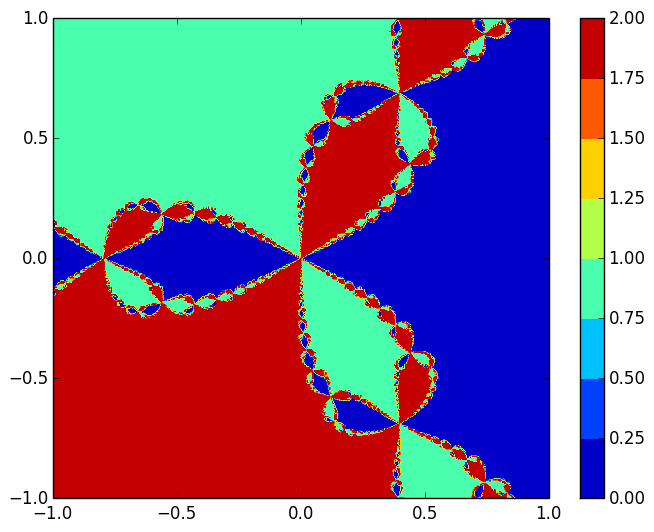

PyObject <matplotlib.colorbar.Colorbar instance at 0x120cd5dd0>

In [14]:
contourf(linspace(-1,1,n),linspace(-1,1,n),Imag)
colorbar()

## Boucle parallèle

In [15]:
addprocs(2); # on ajoute 2 processeurs

2-element Array{Any,1}:
 4
 5

Dans un premier temps on redéfinie les fonctions newton, f et df pour tous les workers à l'aide de la macro @everywhere

In [16]:
# algorithme de Newton
@everywhere function newton(x0,f,df,epsi)
    k=0;
    x=x0;
    xnew=x-df(x)\f(x);
    while (norm(x-xnew)>epsi)&(k<1000)
        x=xnew
        xnew=x-df(x)\f(x);
    end
    return xnew
end
# fonction f(x)=0 à résoudre ici z=x+iy et f(z)=z^3-1
@everywhere f(x)=[x[1]^3-3*x[1]*x[2]^2-1,3*x[1]^2*x[2]-x[2]^3]
# le jacobien de f
@everywhere df(x)=[3*x[1]^2-3*x[2]^2 -6*x[1]*x[2];6*x[1]*x[2] 3*x[1]^2-3*x[2]^2]
# Calcul du bassin si on converge vers la Ieme racine suivant le point de départ

Puis on uitlise @parallel dans la boucle extérieure ainsi que @sync pour resynchroniser les process autrement attendre que tous les workers aient fini leurs calculs 

In [17]:
function calc_bassin(f,df,n)
    x=linspace(-1,1,n);
    y=linspace(-1,1,n);
    Imag=SharedArray(Int,(n,n));
    @sync begin
        @parallel for i=1:n
             for j=1:n
                r=newton([x[i],y[n-j+1]],f,df,1e-10)
                Imag[j,i]=int(round(atan2(r[2],r[1])*3/pi)+3)%3;
            end
        end
    end
    return Imag
end

calc_bassin (generic function with 1 method)

In [18]:
n=512 # efficacité pas très grande
@time Imag=calc_bassin(f,df,n); 

elapsed time: 3.565591268 seconds (2286600 bytes allocated)


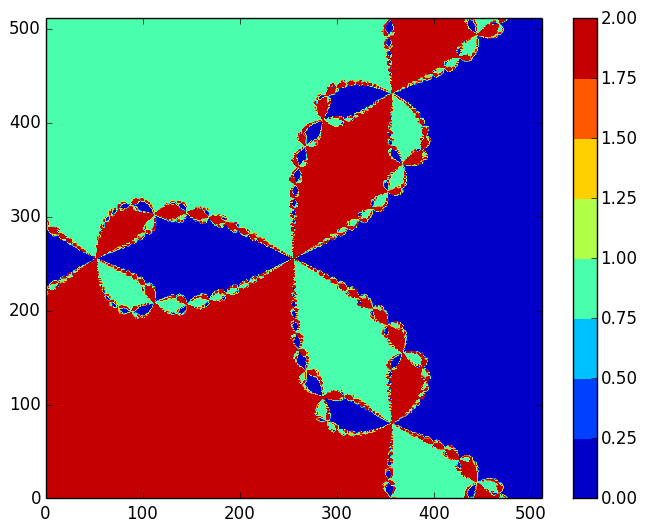

PyObject <matplotlib.colorbar.Colorbar instance at 0x1224bf758>

In [19]:
contourf(Imag)
colorbar()

# Encore plus de //

On a utilisé les macros <code>@everywhere</code> <code>@parallel</code> <code>@sync</code>
regardons 

* <code>remotecall</code> appel asynchrone (n'attends pas le résultat dit appel non bloquant)
* <code>fetch</code> récupère le résultat (synchronise)
* <code>remotecall_fetch</code> les 2 commandes précédentes réunies ou appel bloquant (tant que le résultat n'est pas calculé la fonction ne rend pas la main.
* <code>remotecall_wait</code>
* <code>@spawn</code> et <code>@spawnat</code> macros pour <code>remotecall</code>


In [20]:
for proc=workers()
    println(remotecall_fetch(proc,myid)) # demande l'exécution de myid() sur chaque proc
end

2
3
4
5


In [21]:
a=zeros(nworkers())
for i=1:nworkers()
    a[i]=remotecall_fetch(i+1,myid)
end
println(a) # a contien les numéros des workers  

[2.0,3.0,4.0,5.0]


In [22]:
for i=1:10
   # spawn the process  
   r = @spawn rand()  

   # print out the results  
    
    println("process: $(r.where) int: $(fetch(r)) \n")  
 end  

process: 2 int: 0.8898241279678305 

process: 3 int: 0.8412918106677134 

process: 4 int: 0.2950537943049809 

process: 5 int: 0.0816639999226989 

process: 2 int: 0.6194974016710659 

process: 3 int: 0.8400850555226036 

process: 4 int: 0.7153192675906841 

process: 5 int: 0.43020425492900727 

process: 2 int: 0.7287124352443148 

process: 3 int: 0.49285348146084074 



In [23]:
# Calcul du bassin si on converge vers la Ieme racine suivant le point de départ
function calc_bassin(f,df,n)
    x=linspace(-1,1,n);
    y=linspace(-1,1,n);
    Remot=Array(Any,(n,n))
    Imag=zeros(n,n);
    k=0
    wo=workers()
    nw=nworkers()
    for i=1:n
      for j=1:n
            k=k+1
            wk=wo[k%nw+1]
            Remot[i,j]=remotecall(wk,newton,[x[i],y[j]],f,df,1e-10)
      end
    end     
    
    for i=1:n
      for j=1:n
            r=fetch(Remot[i,j])
            if (norm(r-[1,0])<1e-2)
                Imag[i,j]=1;
            elseif (norm(r-[cos(2*pi/3),sin(2*pi/3)])<1e-2)
                Imag[i,j]=2;
            elseif (norm(r-[cos(2*pi/3),-sin(2*pi/3)])<1e-2)
                Imag[i,j]=3;
            end
        end
    end
    return Imag
end

calc_bassin (generic function with 1 method)